# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>2. Naive Bayes </h1>

In [116]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from collections import Counter
import math

## 1.1 Loading Data

In [117]:
# make sure you are loading atleast 50k datapoints
# you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('/content/drive/MyDrive/Case Studies/6_Donors_choose_NB/preprocessed_data.csv')

In [118]:
data.shape

(109248, 9)

* This data is non Trivial to work with according to our sysem's specifications.Hence it's better to use small proportion of it.

In [119]:
data = data.head(35000)

print(data.shape)
data.head(3)

(35000, 9)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [120]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

* Before splitting the dataset we have to drop the Target column 

In [121]:
y = data['project_is_approved'].values

X = data.drop(['project_is_approved'], axis = 1)
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [122]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [123]:
%%time 
# around 1m 20sec for 35k data points

# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)

vectorizer = CountVectorizer(min_df = 10,ngram_range = (1,3), max_features = 5000)

vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")

print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)

After vectorizations
(23450, 5000) (23450,)
(11550, 5000) (11550,)
CPU times: user 43.6 s, sys: 629 ms, total: 44.2 s
Wall time: 45.2 s


In [124]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 3),max_features = 6000, min_df = 10)

vectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf  = vectorizer.transform(X_test['essay'].values)

# we are converting a dictionary with word as a key, and the idf as a value

dictionary  = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(dictionary.keys())

In [125]:
tf_idf_feature_list = vectorizer.get_feature_names()

print(len(tf_idf_feature_list))
tf_idf_feature_list[-5:]

6000


['your donations', 'your generous', 'your generous donation', 'youth', 'zone']

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

## Encoding Categorical Columns

**School State**

In [126]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe  = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")

print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)

state_ohe_feature_list = vectorizer.get_feature_names()

print(len(state_ohe_feature_list),state_ohe_feature_list[-5:])

After vectorizations
(23450, 51) (23450,)
(11550, 51) (11550,)
51 ['vt', 'wa', 'wi', 'wv', 'wy']


**teacher_prefix**

In [127]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe  = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)

teacher_ohe_feature_list = vectorizer.get_feature_names()

print(len(teacher_ohe_feature_list),teacher_ohe_feature_list[-5:])

After vectorizations
(23450, 5) (23450,)
(11550, 5) (11550,)
5 ['dr', 'mr', 'mrs', 'ms', 'teacher']


**project_grade_category**

In [157]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)


grade_ohe_feature_list = vectorizer.get_feature_names()

print(len(grade_ohe_feature_list),grade_ohe_feature_list[-3:])

After vectorizations
(23450, 4) (23450,)
(11550, 4) (11550,)
4 ['grades_6_8', 'grades_9_12', 'grades_prek_2']


**clean_categories**

In [129]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_category_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_category_ohe  = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_category_ohe.shape, y_train.shape)
print(X_test_category_ohe.shape, y_test.shape)


category_ohe_feature_list = vectorizer.get_feature_names()

print(len(category_ohe_feature_list),category_ohe_feature_list[-5:])

After vectorizations
(23450, 7) (23450,)
(11550, 7) (11550,)
7 ['history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds']


**clean_subcategories**

In [130]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_category_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_sub_category_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_sub_category_ohe.shape, y_train.shape)
print(X_test_sub_category_ohe.shape, y_test.shape)

sub_category_ohe_feature_list = vectorizer.get_feature_names()

print(len(sub_category_ohe_feature_list),sub_category_ohe_feature_list[-5:])

After vectorizations
(23450, 28) (23450,)
(11550, 28) (11550,)
28 ['performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts']


In [131]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().


## Encoding Numerical Features

**Price**

https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

* Normalizer is applied Row-wise, Hence it can be used when we have to normalize the BOW/TF-IDF features as they have around 50k features. but if we want to normalize single feature "Age" it would just return 1.

* standard Scaler is applied column-wise so this is better choice here but negative values will not work with Naive Bayes

* Hence we should use MinMax scaler

In [132]:
# In case of Normalization

# reshape(-1,1) -- > any number of rows and 1 column  but in our data we have column vector/(one feature only) Hence normalizer will 
# make all values of column == 1.0 . 

# reshape(1,-1)  -- this will work fine bcz we will have only one row and Normalizer works along the rows, but it is giving an error 

In [133]:
from sklearn.preprocessing import StandardScaler
# scaler can also be applied to sparse CSR or CSC matrices by passing with_mean=False
# to avoid breaking the sparsity structure of the data.

sc = StandardScaler(copy = True,with_mean = True,with_std = True)
sc.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm  =  sc.fit_transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm   =  sc.fit_transform(X_test['price'].values.reshape(-1,1))

print("Mean--",sc.mean_)
print("std --",np.sqrt(sc.var_))

print(X_train_price_norm.shape)
print(X_train_price_norm.shape)

print(X_train_price_norm[0])

Mean-- [301.84234286]
std -- [341.69947266]
(23450, 1)
(23450, 1)
[0.14577582]


## Concatenating the Features

In [134]:
print(X_train_essay_bow.shape)
print(X_train_state_ohe.shape)
print(X_train_teacher_ohe.shape)
print(X_train_grade_ohe.shape)
print(X_train_category_ohe.shape)
print( X_train_sub_category_ohe.shape)
print(X_train_price_norm.shape)
print(X_train_price_norm.shape)

print(X_test_price_norm.shape)

(23450, 5000)
(23450, 51)
(23450, 5)
(23450, 4)
(23450, 7)
(23450, 28)
(23450, 1)
(23450, 1)
(11550, 1)


In [135]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_category_ohe,
               X_train_sub_category_ohe,X_train_price_norm)).tocsr()

X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_category_ohe,
               X_test_sub_category_ohe,X_test_price_norm)).tocsr()

In [136]:
print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(23450, 5096) (23450,)
(11550, 5096) (11550,)


In [137]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100] 
log_alpha = list(map(lambda x : math.log10(x), alpha))


naive_bayes = MultinomialNB()

parameters  = { 'alpha':log_alpha }
clf         = RandomizedSearchCV(naive_bayes, parameters, cv = 3, scoring = 'roc_auc',return_train_score =  True)
clf.fit(X_tr, y_train)

ValueError: ignored

* Hence we cannot pass negative values to Naive Bayes.so we have to improvise our scaling

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [138]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
sc.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm  =  sc.fit_transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm   =  sc.fit_transform(X_test['price'].values.reshape(-1,1))

print(sc.data_min_)
print(sc.data_max_)

print(X_train_price_norm.shape)
print(X_train_price_norm.shape)

print(X_train_price_norm[0])

[0.69]
[9534.67]
(23450, 1)
(23450, 1)
[0.03535172]


In [139]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_category_ohe,
               X_train_sub_category_ohe,X_train_price_norm)).tocsr()

X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_category_ohe,
               X_test_sub_category_ohe,X_test_price_norm)).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(23450, 5096) (23450,)
(11550, 5096) (11550,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

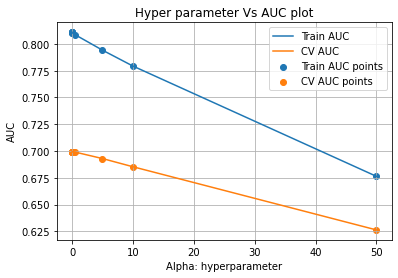

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
7,0.023458,0.001023,0.014969,0.000343,0.00001,{'alpha': 1e-05},0.697002,0.701578,0.699290,0.002288,6,0.815560,0.806196,0.810878,0.004682
8,0.022836,0.000004,0.014637,0.000336,0.0001,{'alpha': 0.0001},0.697127,0.701659,0.699393,0.002266,5,0.815504,0.806143,0.810824,0.004681
0,0.027885,0.004189,0.014566,0.000419,0.0005,{'alpha': 0.0005},0.697210,0.701702,0.699456,0.002246,4,0.815451,0.806083,0.810767,0.004684
5,0.022458,0.000008,0.019499,0.005028,0.001,{'alpha': 0.001},0.697242,0.701717,0.699479,0.002237,3,0.815423,0.806051,0.810737,0.004686
6,0.022474,0.000682,0.014870,0.000519,0.01,{'alpha': 0.01},0.697353,0.701732,0.699543,0.002190,1,0.815290,0.805880,0.810585,0.004705


In [140]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot



from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.naive_bayes import MultinomialNB

alpha     = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100] 

naive_bayes = MultinomialNB()
parameters  = { 'alpha':alpha }
clf         = RandomizedSearchCV(naive_bayes, parameters, cv = 2, scoring = 'roc_auc',return_train_score =  True)
search      = clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc     = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc        = results['mean_test_score'] 
cv_auc_std    = results['std_test_score']
param_alpha   = results['param_alpha']

plt.plot(param_alpha, train_auc, label='Train AUC')
plt.plot(param_alpha, cv_auc, label='CV AUC')

plt.scatter(param_alpha, train_auc, label='Train AUC points')
plt.scatter(param_alpha, cv_auc,    label='CV AUC points')


plt.legend()

plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")

plt.title("Hyper parameter Vs AUC plot")

plt.grid()
plt.show()

results.head()

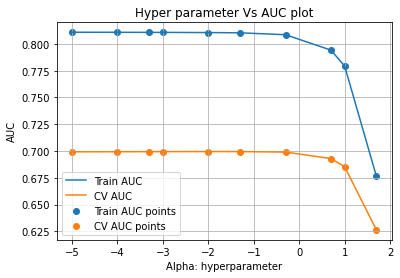

optimal Alpha:- {'alpha': 0.01}


In [141]:
log_alpha = list(map(lambda x : math.log10(x), param_alpha))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc,    label='CV AUC points')


plt.legend()

plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")

plt.title("Hyper parameter Vs AUC plot")

plt.grid()
plt.show()

print("optimal Alpha:-",search.best_params_)

 https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

In [142]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

from sklearn.metrics import roc_curve, auc


nb = MultinomialNB(alpha = 0.005)
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict_proba(X_tr)[:,1]
y_test_pred  = nb.predict_proba(X_te)[:,1]

y_test_pred

array([9.60797448e-19, 9.92448787e-01, 4.32229575e-04, ...,
       1.00000000e+00, 9.99999844e-01, 9.97788890e-01])

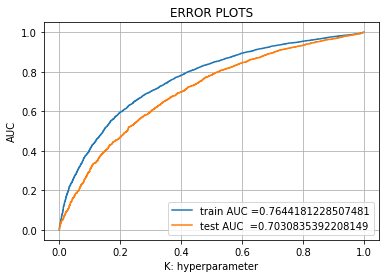

In [143]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

In [144]:
print( test_fpr[:-3] ) # printing last three values 

print(1 - test_fpr[:-3]) # printing 1 - last three values 

[0.00000000e+00 5.64334086e-04 1.12866817e-03 ... 9.98306998e-01
 9.98871332e-01 9.98871332e-01]
[1.         0.99943567 0.99887133 ... 0.001693   0.00112867 0.00112867]


In [145]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [146]:
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr) # find threshold using train data and predict both train and test data.

print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4930464665285133 for threshold 0.85
Train confusion matrix
[[ 2584  1015]
 [ 6219 13632]]
Test confusion matrix
[[1122  650]
 [3209 6569]]


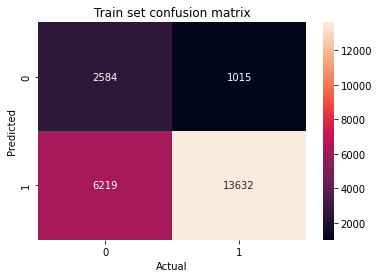

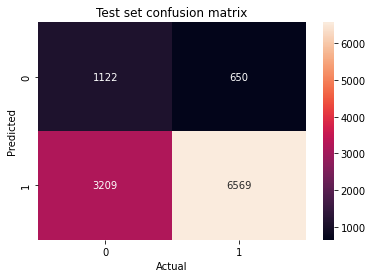

In [147]:
# Heatmap for train set confusion matrix(Select K best)

heatmap_train = sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred,best_t)), annot = True, fmt = "d")

plt.title("Train set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

# Heatmap for test set confusion matrix(Select K best)

heatmap_train = sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot = True, fmt = "d")

plt.title("Test set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

#### Set 2, TF-IDF

In [148]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_category_ohe,
               X_train_sub_category_ohe,X_train_price_norm)).tocsr()

X_te = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_category_ohe,
               X_test_sub_category_ohe,X_test_price_norm)).tocsr()

In [149]:
print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(23450, 6096) (23450,)
(11550, 6096) (11550,)


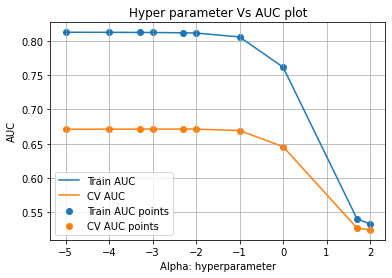

optimal Alpha:- {'alpha': 0.001}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
5,0.024318,0.000673,0.014726,0.000131,0.00001,{'alpha': 1e-05},0.665425,0.676518,0.670971,0.005547,6,0.811517,0.813003,0.812260,0.000743
9,0.022984,0.000957,0.014639,0.000243,0.0001,{'alpha': 0.0001},0.665502,0.676742,0.671122,0.005620,5,0.811434,0.812850,0.812142,0.000708
2,0.025890,0.002306,0.015055,0.000259,0.0005,{'alpha': 0.0005},0.665557,0.676860,0.671209,0.005651,3,0.811333,0.812668,0.812000,0.000667
8,0.022912,0.000041,0.014943,0.000855,0.001,{'alpha': 0.001},0.665580,0.676893,0.671236,0.005657,1,0.811261,0.812554,0.811907,0.000647
4,0.022495,0.000416,0.014773,0.000097,0.005,{'alpha': 0.005},0.665555,0.676910,0.671232,0.005678,2,0.810879,0.812090,0.811485,0.000605


In [150]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot



from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.naive_bayes import MultinomialNB

alpha     = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100] 

naive_bayes = MultinomialNB()
parameters  = { 'alpha':alpha }
clf         = RandomizedSearchCV(naive_bayes, parameters, cv = 2, scoring = 'roc_auc',return_train_score =  True)
search      = clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc     = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc        = results['mean_test_score'] 
cv_auc_std    = results['std_test_score']
param_alpha   = results['param_alpha']

log_alpha = list(map(lambda x : math.log10(x), param_alpha))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc,    label='CV AUC points')


plt.legend()

plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")

plt.title("Hyper parameter Vs AUC plot")

plt.grid()
plt.show()

print("optimal Alpha:-",search.best_params_)

results.head()

In [151]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

from sklearn.metrics import roc_curve, auc


nb = MultinomialNB(alpha = 0.005)
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict_proba(X_tr)[:,1]
y_test_pred  = nb.predict_proba(X_te)[:,1]

y_test_pred


array([0.23470863, 0.8832076 , 0.6740238 , ..., 0.97105433, 0.92215006,
       0.90993201])

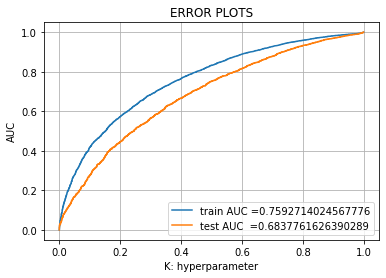

In [152]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
# Plot the ROC-AUC curves using the probability predictions made on train and test data.

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

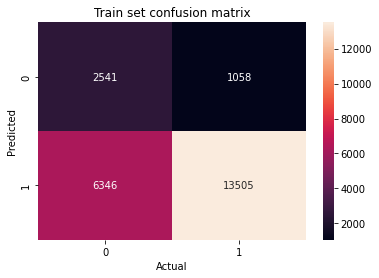

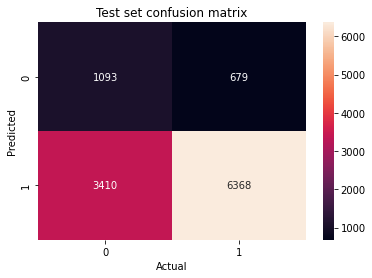

In [153]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)

def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


heatmap_train = sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred,best_t)), annot = True, fmt = "d")

plt.title("Train set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

# Heatmap for test set confusion matrix

heatmap_train = sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot = True, fmt = "d")

plt.title("Test set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

In [154]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)

# first of all we have to get the feature_log_probabilities

print(nb.feature_log_prob_[:, :].shape) # 2 classes 0 and 1 with 6096 columns 

print(X_train_essay_tfidf.shape)
print(X_train_state_ohe.shape)
print(X_train_teacher_ohe.shape)
print(X_train_grade_ohe.shape)
print(X_train_category_ohe.shape)
print(X_train_sub_category_ohe.shape)
print(X_train_price_norm.shape)

# Hence 6000+51+4+7+28+1 = 60296

(2, 6096)
(23450, 6000)
(23450, 51)
(23450, 5)
(23450, 4)
(23450, 7)
(23450, 28)
(23450, 1)


In [161]:
feature_list = []

feature_list.extend(tf_idf_feature_list)
feature_list.extend(state_ohe_feature_list)
feature_list.extend(teacher_ohe_feature_list)
feature_list.extend(grade_ohe_feature_list)
feature_list.extend(category_ohe_feature_list)
feature_list.extend(sub_category_ohe_feature_list)
feature_list.append('Price')

print(len(feature_list))
print(feature_list[-5:])

6096
['socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'Price']


**Positive Class**

https://www.adamsmith.haus/python/answers/how-to-sort-a-numpy-array-in-descending-order-in-python


https://www.adamsmith.haus/python/docs/numpy.argsort

In [187]:
print(type(nb.feature_log_prob_[1, :]))
# here we would like to extract indices of top 20 features of positive class 

positive_prob_array   = nb.feature_log_prob_[1, :]# Storing all the probability values of features
print(positive_prob_array[-5:])

feature_index_array    = np.argsort(nb.feature_log_prob_[1, :])[-20:] # it will give last 20 features but we want last 20 in reverse order

feature_index_array    = np.flip(feature_index_array) 
feature_index_array 

<class 'numpy.ndarray'>
[-6.71747919 -5.02243007 -6.80724801 -5.82677275 -6.34758936]


array([6053, 6063, 6059, 6054, 6056, 6064, 6083, 6085, 6084, 6061, 6081,
       6057, 6004, 4781, 6092, 6066, 6060, 6058, 6067, 6052])

In [189]:
most_imp_features = []

for index in feature_index_array:

  print(feature_list[index],positive_prob_array[index])

mrs -3.4046837139801163
literacy_language -3.5253328631971694
grades_prek_2 -3.6573388100535613
ms -3.8531280545764215
grades_3_5 -3.872023951900932
math_science -3.8752573444641616
literacy -3.9661168986726345
mathematics -4.244225679171322
literature_writing -4.343524958813344
health_sports -4.397879534558504
health_wellness -4.625189830480574
grades_6_8 -4.7665420806811465
ca -4.843747085091602
students -4.927735393694168
specialneeds -5.022430065286234
specialneeds -5.022430065286234
appliedlearning -5.024750785007961
grades_9_12 -5.201696033351688
appliedsciences -5.2723539811236595
mr -5.2747377653758765


**Using DataFrame**

In [190]:
feature_importance = pd.DataFrame({ "Feature Names":feature_list,"Log-Probabilitis":positive_prob_array})

feature_importance.head()

,Feature Names,Log-Probabilitis
0,000,-10.075704
1,10,-8.893757
2,100,-8.352881
3,100 free,-9.727245
4,100 percent,-10.249199


In [193]:
top_features = feature_importance.sort_values(by = ['Log-Probabilitis'],ascending = False,inplace = False)

top_features.head(20)

,Feature Names,Log-Probabilitis
6053,mrs,-3.404684
6063,literacy_language,-3.525333
6059,grades_prek_2,-3.657339
6054,ms,-3.853128
6056,grades_3_5,-3.872024
6064,math_science,-3.875257
6083,literacy,-3.966117
6085,mathematics,-4.244226
6084,literature_writing,-4.343525
6061,health_sports,-4.397880


**-ve class**

In [195]:
negative_prob_array   = nb.feature_log_prob_[0, :]# Storing all the probability values of features
print(negative_prob_array[-5:])

[-6.70154511 -4.88922445 -6.33384169 -5.64071855 -6.10035575]


In [198]:
feature_importance = pd.DataFrame({ "Feature Names":feature_list,"Log-Probabilitis":negative_prob_array})

top_features = feature_importance.sort_values(by = ['Log-Probabilitis'],ascending = False,inplace = False)

top_features.head(20)

,Feature Names,Log-Probabilitis
6053,mrs,-3.448335
6063,literacy_language,-3.621998
6059,grades_prek_2,-3.629690
6064,math_science,-3.768937
6054,ms,-3.792890
6056,grades_3_5,-3.909253
6083,literacy,-4.118661
6085,mathematics,-4.126033
6084,literature_writing,-4.381128
6061,health_sports,-4.469504


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [202]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["SET","Best Alpha", "Train AUC","Test AUC"]

x.add_row(["Set1",0.005,0.764,0.70])
x.add_row(["Set2",0.005,0.759,0.6845])

print(x)

+------+------------+-----------+----------+
| SET  | Best Alpha | Train AUC | Test AUC |
+------+------------+-----------+----------+
| Set1 |   0.005    |   0.764   |   0.7    |
| Set2 |   0.005    |   0.759   |  0.6845  |
+------+------------+-----------+----------+
